<a href="https://colab.research.google.com/github/evinracher/3010090-ontological-engineering/blob/main/week2/part3/03_Mensajes_anotados%26funciones_Reducer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Annotated Construct and Reducer Functions

### Set the OpenAI API Key as an Environment Variable

In [1]:
from google.colab import userdata
import os

api_key = userdata.get('GOOGLE_API_KEY')
os.environ['GOOGLE_API_KEY'] = api_key
print('API Key cargada:', 'Sí' if api_key else 'No')

API Key cargada: Sí


### Import Relevant Classes and Functions

In [2]:
from langgraph.graph import START, END, StateGraph, add_messages
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from collections.abc import Sequence
from typing import Literal, Annotated

### Get Familiar with the add_messages Function

In [3]:
my_list = add_messages([HumanMessage("Hi! I'm Oscar."),
                        AIMessage("Hey, Oscar. How can I assist you?")],
                       [HumanMessage("Could you summarize today's news?")])

In [4]:
my_list

[HumanMessage(content="Hi! I'm Oscar.", additional_kwargs={}, response_metadata={}, id='037e15b8-3915-4770-9131-a3fba34e5632'),
 AIMessage(content='Hey, Oscar. How can I assist you?', additional_kwargs={}, response_metadata={}, id='2509e5ce-e612-4ee7-ab99-ee503f3bf62a', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content="Could you summarize today's news?", additional_kwargs={}, response_metadata={}, id='036c18f5-261f-4ad6-bf9b-e98939d1da2e')]

### Define the State

In [5]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Define the Nodes

### Set model up


In [6]:
!pip install langchain-google-genai
from langchain_google_genai import ChatGoogleGenerativeAI

chat = ChatGoogleGenerativeAI(model="models/gemini-2.5-flash-lite", temperature=0.3, max_output_tokens= 1024)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.6 MB/s eta 0:00:00


In [7]:
def ask_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_question:")

    print("What is your question?")

    return State(messages = [HumanMessage(input())])

In [8]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")

    response = chat.invoke(state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [9]:
def ask_another_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_another_question:")

    print("Would you like to ask one more question (yes/no)?")

    return State(messages = [HumanMessage(input())])

### Define the Routing Function

In [10]:
def routing_function(state: State) -> Literal["ask_question", "__end__"]:

    if state["messages"][0].content == "yes":
        return "ask_question"
    else:
        return "__end__"

### Define the Graph

In [11]:
graph = StateGraph(State)

In [12]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question",
                            path = routing_function)

In [13]:
graph_compiled = graph.compile()

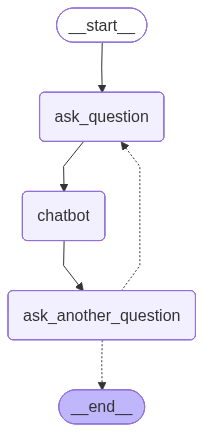

In [14]:
graph_compiled

### Test the Graph

In [16]:
graph_compiled.invoke(State(messages = []))


-------> ENTERING ask_question:
What is your question?
Cuantos habitantes tiene medellin?

-------> ENTERING chatbot:


ChatGoogleGenerativeAIError: Error calling model 'models/gemini-2.5-flash-lite' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash-lite\nPlease retry in 27.360361664s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', 'location': 'global'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '27s'}]}}